In [1]:
from statsmodels.tsa.stattools import grangercausalitytests as granger
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import pandas as pd
import pyEDM as edJm
import numpy as np
import time
import os

# %matplotlib notebook

In [2]:
filename = "avas8"

# let's make our features more human-readable
features = {
    "zzSCENARIO/SYSTEM_TIME" : "Time",
    "GAE/ACPHIR"             : "Roll",
    "GAE/THETAR"             : "Pitch",
    "GAE/ACPSIR"             : "Yaw",
    "GAE/ACALTF"             : "Altitude",
    "GAE/IAIRSPK"            : "Airspeed",
    "GAE/Z1DOTF"             : "Vertical Velocity",
    "GAE/UBODYF"             : "X Acceleration",
    "GAE/VBODYF"             : "Y Acceleration",
    "GAE/WBODYF"             : "Z Acceleration",
}

# we'll probably need these later
units = {
    "Time"              : "seconds",
    "Roll"              : "degrees",
    "Pitch"             : "degrees",
    "Altitude"          : "feet",
    "Airspeed"          : "feet/second",
    "Vertical Velocity" : "feet/second",
    "X Acceleration"    : "feet/second$^2$",
    "Y Acceleration"    : "feet/second$^2$",
    "Z Acceleration"    : "feet/second$^2$"
}

# pull in the dataset; rename and reorder the columns
df = pd.read_csv("/Users/david/Documents/masters/thesis/data/avas/edm/{}.csv".format(filename))
df = df.rename(columns=features)
df = df[list(features.values())]

# convert radians to degrees
for label in ["Roll", "Pitch"]:
    df[label] = df[label] * 180 / np.pi

# fix the negative series
df["Vertical Velocity"] *= -1
df["Y Acceleration"] *= -1

# show it
display(df.head(5))

,Time,Roll,Pitch,Yaw,Altitude,Airspeed,Vertical Velocity,X Acceleration,Y Acceleration,Z Acceleration
0,0.00,0.0,0.0,0.0,1.00282,0.000000,-0.0,0.000000,-0.0,0.000000
1,0.11,0.0,0.0,0.0,1.00282,0.071092,-0.0,0.118377,-0.0,0.018845
2,0.22,0.0,0.0,0.0,1.00282,0.550286,-0.0,0.927651,-0.0,0.018904
3,0.33,0.0,0.0,0.0,1.00282,1.030200,-0.0,1.736920,-0.0,0.018904
4,0.44,0.0,0.0,0.0,1.00282,1.510140,-0.0,2.546190,-0.0,0.018912


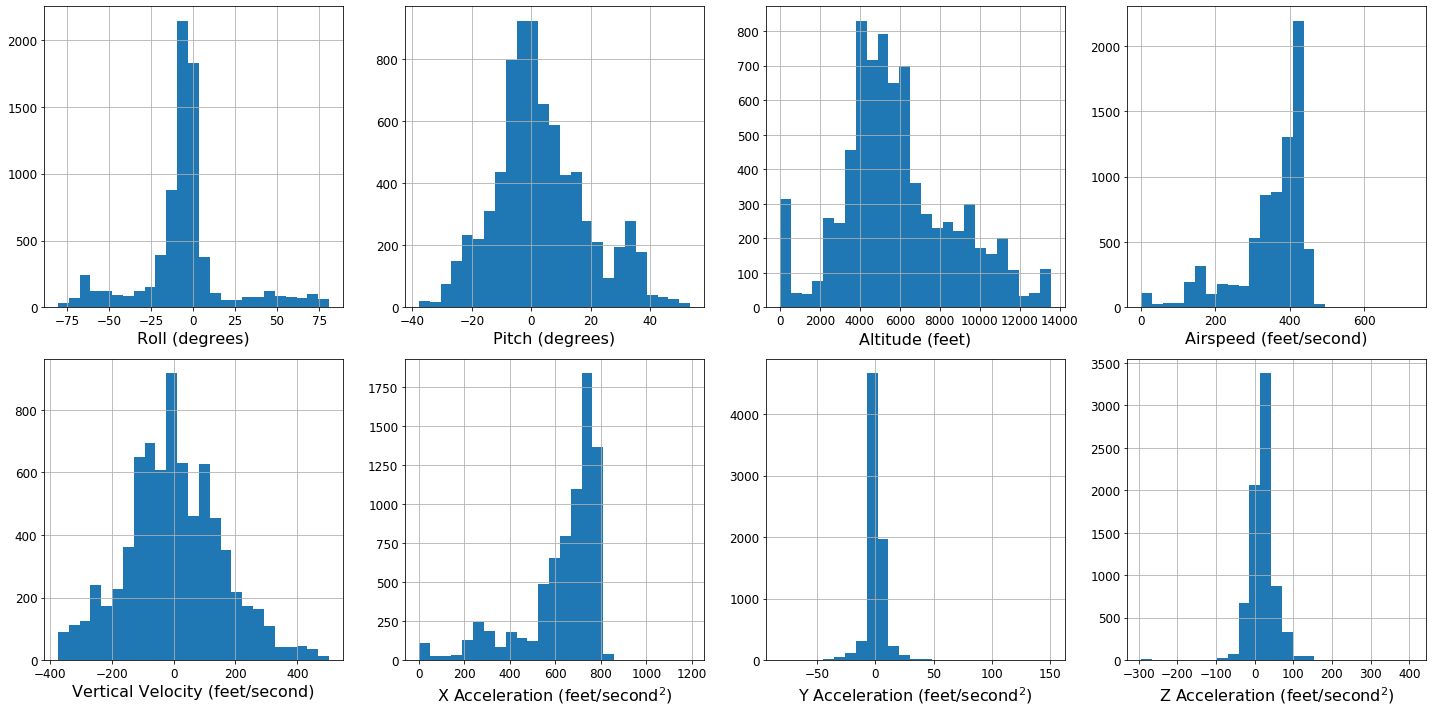

In [3]:
attributes = df.drop(columns=["Time", "Yaw"]).columns
locations = [1, 2, 3, 4, 5, 6, 7, 8]
fig = plt.figure(figsize=(20,10))

label_size = 16
tick_size = 12

# create a histogram for each feature
ax = []
for i, feature in enumerate(attributes):
    ax.append(fig.add_subplot(2, 4, locations[i]))
    ax[i] = df[feature].hist(bins=25)

    # change font sizes; label the x-axis with the feature and its units
    ax[i].set_xlabel(feature + " (" + units[feature] + ")", fontsize=label_size)
    ax[i].xaxis.set_tick_params(labelsize=tick_size)
    ax[i].yaxis.set_tick_params(labelsize=tick_size)
    
fig.tight_layout()
# fig.savefig("/Users/david/Documents/masters/thesis/images/AVASHistogram.png", dpi=200)

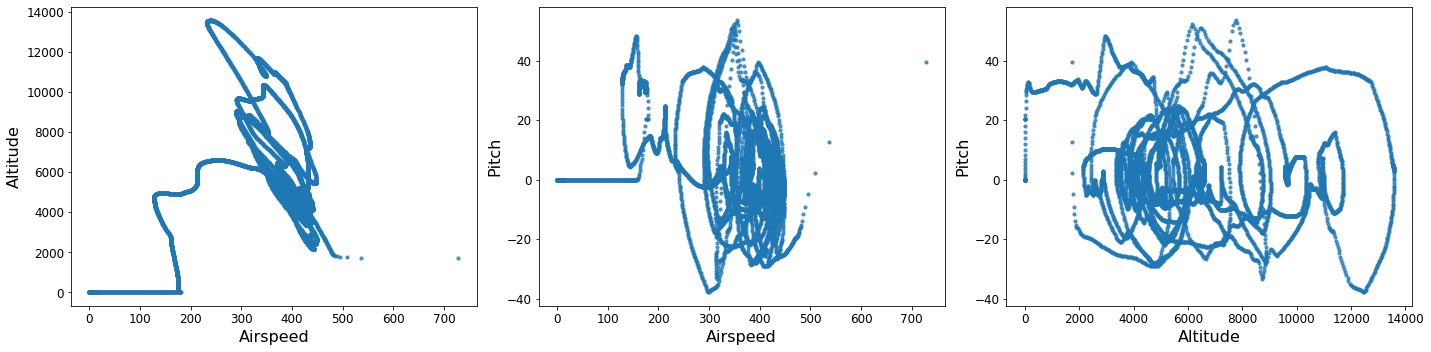

In [4]:
# makes things easier
times = df["Time"]
labels = ["Airspeed", "Altitude", "Pitch"]
xlab, ylab, zlab = labels[0], labels[1], labels[2]
x, y, z = df[xlab], df[ylab], df[zlab]

fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].scatter(x, y, s=10, alpha=0.75)
ax[1].scatter(x, z, s=10, alpha=0.75)
ax[2].scatter(y, z, s=10, alpha=0.75)

ax[0].set_xlabel(xlab, fontsize=label_size)
ax[0].set_ylabel(ylab, fontsize=label_size)
ax[0].xaxis.set_tick_params(labelsize=tick_size)
ax[0].yaxis.set_tick_params(labelsize=tick_size)

ax[1].set_xlabel(xlab, fontsize=label_size)
ax[1].set_ylabel(zlab, fontsize=label_size)
ax[1].xaxis.set_tick_params(labelsize=tick_size)
ax[1].yaxis.set_tick_params(labelsize=tick_size)

ax[2].set_xlabel(ylab, fontsize=label_size)
ax[2].set_ylabel(zlab, fontsize=label_size)
ax[2].xaxis.set_tick_params(labelsize=tick_size)
ax[2].yaxis.set_tick_params(labelsize=tick_size)

fig.tight_layout()
# fig.savefig("/Users/david/Documents/masters/thesis/images/AVASNonlinearRelationships.png", dpi=200)

In [5]:
# scale each series
for column in df.drop(columns="Time"):
    df[column] = (df[column] - np.min(df[column])) / np.ptp(df[column])

/Users/david/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


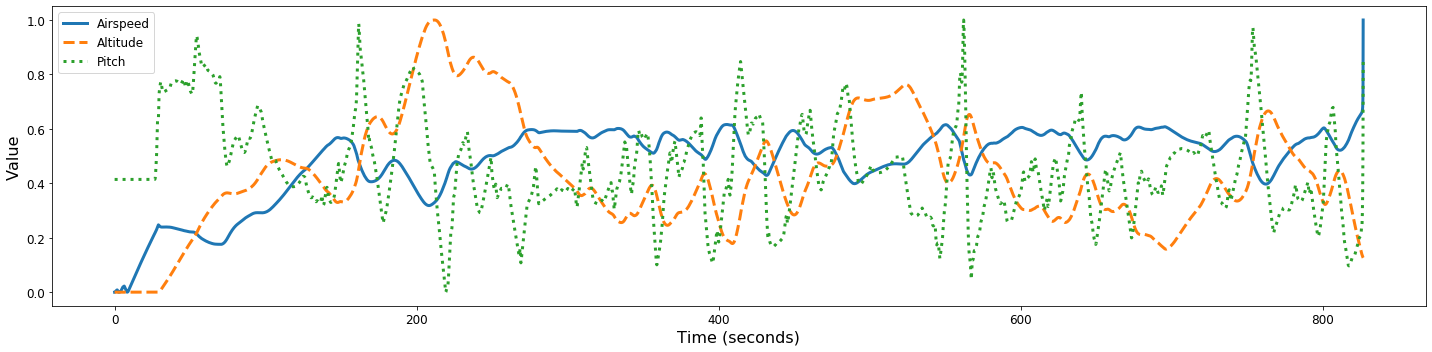

In [6]:
# plot everything
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(times, x, label=labels[0], linewidth=3, linestyle="-")
ax.plot(times, y, label=labels[1], linewidth=3, linestyle="--")
ax.plot(times, z, label=labels[2], linewidth=3, linestyle=":")

ax.set_xlabel("Time (seconds)", fontsize=label_size)
ax.set_ylabel("Value", fontsize=label_size)
ax.xaxis.set_tick_params(labelsize=tick_size)
ax.yaxis.set_tick_params(labelsize=tick_size)

ax.legend(prop={"size": tick_size})
fig.tight_layout()
# fig.savefig("/Users/david/Documents/masters/thesis/images/AVASTimeSeriesScaled.png", dpi=200)

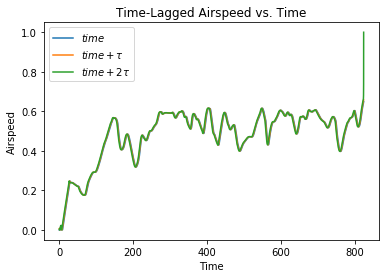

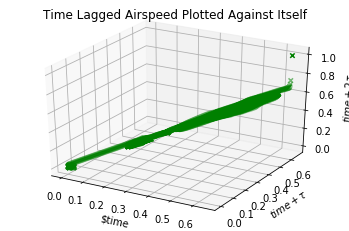

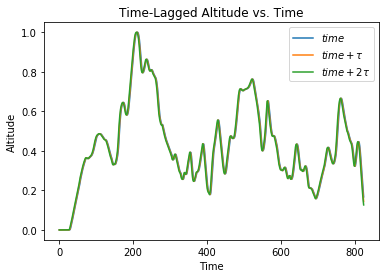

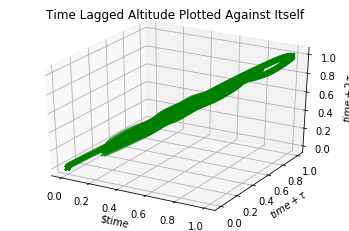

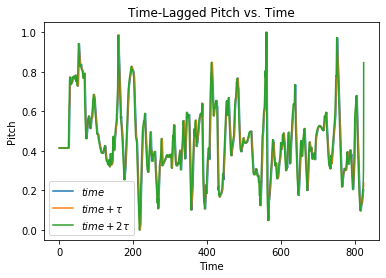

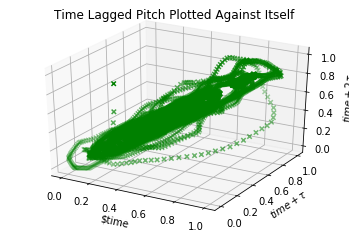

In [7]:
# lag parameter
tau = 10

# plot stuff
for idx, series in enumerate([x, y, z]):
    # plot time-lagged series vs. time
    plt.plot(times[:-2 * tau], series[:-2 * tau], label=r"$time$")
    plt.plot(times[:-2 * tau], series[tau:-tau], label=r"$time+\tau$")
    plt.plot(times[:-2 * tau], series[2 * tau:], label=r"$time+2\tau$")
    
    # pretty-fy
    plt.title("Time-Lagged {} vs. Time".format(labels[idx]))
    plt.xlabel("Time")
    plt.ylabel(labels[idx])
    plt.legend()
    plt.show()
    
    # plot time-lagged series against themselves
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(series[:-2 * tau], series[tau:-tau], series[2 * tau:], color="g", marker="x")
    
    # pretty-fy
    ax.set_xlabel(r"$time")
    ax.set_ylabel(r"$time+\tau$")
    ax.set_zlabel(r"$time+2\tau$")
    ax.set_title("Time Lagged {} Plotted Against Itself".format(labels[idx]))
    plt.show()

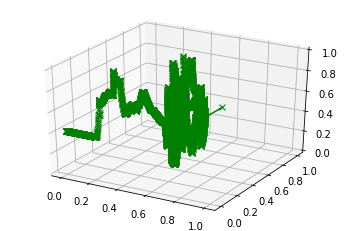

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, color="g", marker="x")

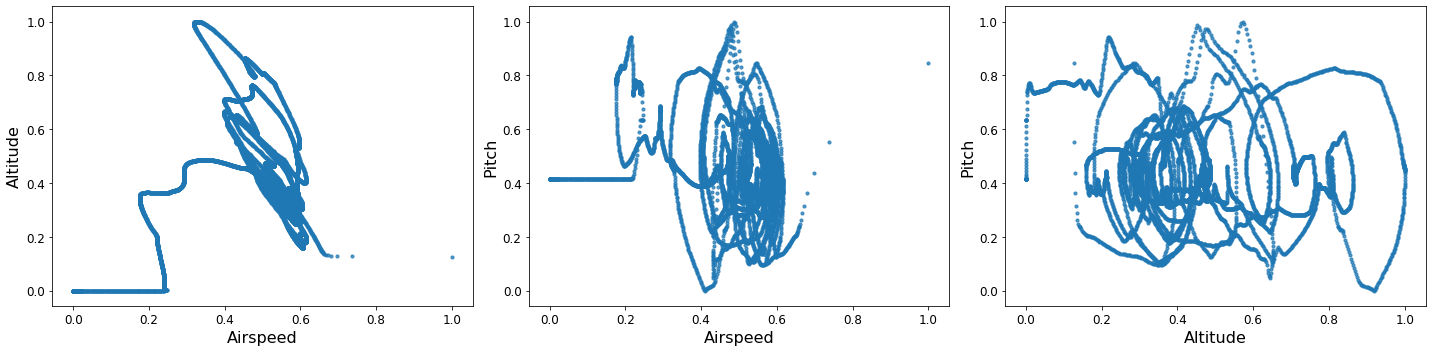

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].scatter(x, y, s=10, alpha=0.75)
ax[1].scatter(x, z, s=10, alpha=0.75)
ax[2].scatter(y, z, s=10, alpha=0.75)

ax[0].set_xlabel(xlab, fontsize=label_size)
ax[0].set_ylabel(ylab, fontsize=label_size)
ax[0].xaxis.set_tick_params(labelsize=tick_size)
ax[0].yaxis.set_tick_params(labelsize=tick_size)

ax[1].set_xlabel(xlab, fontsize=label_size)
ax[1].set_ylabel(zlab, fontsize=label_size)
ax[1].xaxis.set_tick_params(labelsize=tick_size)
ax[1].yaxis.set_tick_params(labelsize=tick_size)

ax[2].set_xlabel(ylab, fontsize=label_size)
ax[2].set_ylabel(zlab, fontsize=label_size)
ax[2].xaxis.set_tick_params(labelsize=tick_size)
ax[2].yaxis.set_tick_params(labelsize=tick_size)

fig.tight_layout()
# fig.savefig("/Users/david/Documents/masters/thesis/images/AVASNonlinearRelationshipsScaled.png", dpi=200)

--------------------
Does Altitude Granger cause Airspeed?



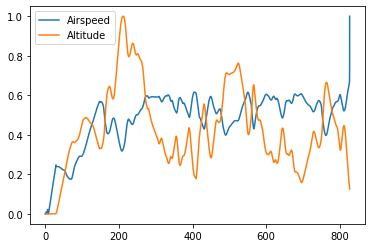


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4137  , p=0.2345  , df_denom=7557, df_num=1
ssr based chi2 test:   chi2=1.4143  , p=0.2343  , df=1
likelihood ratio test: chi2=1.4142  , p=0.2344  , df=1
parameter F test:         F=1.4137  , p=0.2345  , df_denom=7557, df_num=1

Airspeed doesn't g-cause Altitude (p = 0.2345)

--------------------
Does Pitch Granger cause Airspeed?



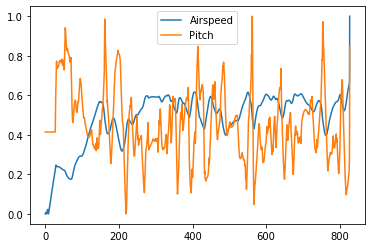


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=275.1613, p=0.0000  , df_denom=7557, df_num=1
ssr based chi2 test:   chi2=275.2705, p=0.0000  , df=1
likelihood ratio test: chi2=270.3775, p=0.0000  , df=1
parameter F test:         F=275.1613, p=0.0000  , df_denom=7557, df_num=1

Airspeed g-causes Pitch (p = 0.0000)

--------------------
Does Airspeed Granger cause Altitude?



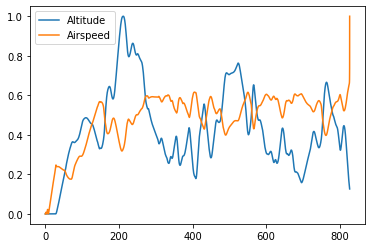


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=435.9591, p=0.0000  , df_denom=7557, df_num=1
ssr based chi2 test:   chi2=436.1322, p=0.0000  , df=1
likelihood ratio test: chi2=424.0159, p=0.0000  , df=1
parameter F test:         F=435.9591, p=0.0000  , df_denom=7557, df_num=1

Altitude g-causes Airspeed (p = 0.0000)

--------------------
Does Pitch Granger cause Altitude?



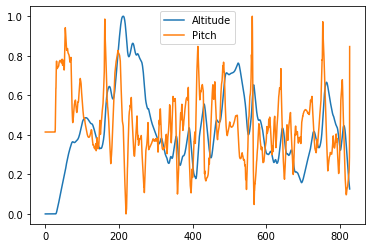


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=48321.0643, p=0.0000  , df_denom=7557, df_num=1
ssr based chi2 test:   chi2=48340.2470, p=0.0000  , df=1
likelihood ratio test: chi2=15125.2739, p=0.0000  , df=1
parameter F test:         F=48321.0643, p=0.0000  , df_denom=7557, df_num=1

Altitude g-causes Pitch (p = 0.0000)

--------------------
Does Airspeed Granger cause Pitch?



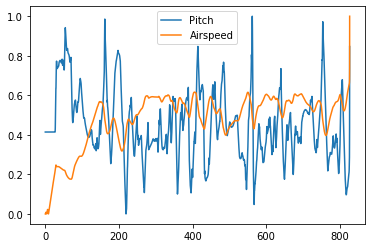


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=150.9431, p=0.0000  , df_denom=7557, df_num=1
ssr based chi2 test:   chi2=151.0030, p=0.0000  , df=1
likelihood ratio test: chi2=149.5147, p=0.0000  , df=1
parameter F test:         F=150.9431, p=0.0000  , df_denom=7557, df_num=1

Pitch g-causes Airspeed (p = 0.0000)

--------------------
Does Altitude Granger cause Pitch?



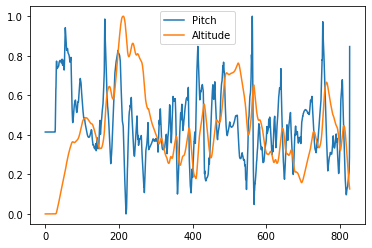


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=230.3671, p=0.0000  , df_denom=7557, df_num=1
ssr based chi2 test:   chi2=230.4585, p=0.0000  , df=1
likelihood ratio test: chi2=227.0157, p=0.0000  , df=1
parameter F test:         F=230.3671, p=0.0000  , df_denom=7557, df_num=1

Pitch g-causes Altitude (p = 0.0000)



In [10]:
# test for granger causality
for i, series_y in enumerate([x, y, z]):
    for j, series_x in enumerate([x, y, z]):
        if i != j:
            print("{}\nDoes {} Granger cause {}?\n".format("-" * 20, labels[j], labels[i]))
            
            plt.plot(times, series_y, label=labels[i])
            plt.plot(times, series_x, label=labels[j])
            plt.legend()
            plt.show()
            
            test_vals = np.vstack((series_y, series_x)).T
            results = granger(test_vals, maxlag=1)
            p_val = results[1][0]["params_ftest"][1]

            # check null hypothesis
            if p_val < 0.05:
                print("\n{} g-causes {} (p = {:.4f})\n".format(labels[i], labels[j], p_val))
            else:
                print("\n{} doesn't g-cause {} (p = {:.4f})\n".format(labels[i], labels[j], p_val))

In [11]:
# test for granger causality
labels = ["Airspeed", "Altitude", "Pitch"]
maxlags = 20 * 10

xy_labels = []
lags = []
p_vals = []

for i, series_y in enumerate([x, y, z]):
    for j, series_x in enumerate([x, y, z]):
        if i != j:
            print("{} Granger-causes {}".format(labels[j], labels[i]))
            
            test_vals = np.vstack((series_y, series_x)).T
            results = granger(test_vals, maxlag=maxlags, verbose=False)
            
            for k in range(10, maxlags + 1, 10):
                xy_labels.append("{} Granger-causes {}".format(labels[j], labels[i]))
                lags.append(k)

                p_vals.append(np.average([
                    results[k][0]["ssr_ftest"][1],
                    results[k][0]["ssr_chi2test"][1],
                    results[k][0]["lrtest"][1],
                    results[k][0]["params_ftest"][1]
                ]))

gdf = pd.DataFrame(np.hstack((
    np.array(xy_labels).reshape(-1,1),
    np.array(lags).reshape(-1,1),
    np.array(p_vals).reshape(-1,1)
)), columns=["Label", "Lags", "P"])

gdf.to_csv("/Users/david/Documents/masters/thesis/data/avas/edm/avas-granger.csv", index=False)

Altitude Granger-causes Airspeed
Pitch Granger-causes Airspeed
Airspeed Granger-causes Altitude
Pitch Granger-causes Altitude
Airspeed Granger-causes Pitch
Altitude Granger-causes Pitch


In [12]:
# test for granger causality
labels = ["Airspeed", "Altitude", "Pitch"]
maxlags = 5

for i, series_y in enumerate([x, y, z]):
    for j, series_x in enumerate([x, y, z]):
        if i != j:
            print("\multirow{5}{*}{%s} & \multirow{5}{*}{%s}" % (labels[j], labels[i]), end="")
            
            test_vals = np.vstack((series_y, series_x)).T
            results = granger(test_vals, maxlag=maxlags, verbose=False)
            
            p_val = np.average([
                results[1][0]["ssr_ftest"][1],
                results[1][0]["ssr_chi2test"][1],
                results[1][0]["lrtest"][1],
                results[1][0]["params_ftest"][1]
            ])
            
            print(" & 1 & {:.4f} \\\\".format(p_val))
            
            for k in range(2, maxlags + 1):
                print("& & {} & {:.4f} \\\\".format(k, np.average([
                    results[k][0]["ssr_ftest"][1],
                    results[k][0]["ssr_chi2test"][1],
                    results[k][0]["lrtest"][1],
                    results[k][0]["params_ftest"][1]
                ])))
            
            print("\midrule")

\multirow{5}{*}{Altitude} & \multirow{5}{*}{Airspeed} & 1 & 0.2344 \\
& & 2 & 0.0000 \\
& & 3 & 0.0000 \\
& & 4 & 0.0000 \\
& & 5 & 0.0000 \\
\midrule
\multirow{5}{*}{Pitch} & \multirow{5}{*}{Airspeed} & 1 & 0.0000 \\
& & 2 & 0.0000 \\
& & 3 & 0.0000 \\
& & 4 & 0.0000 \\
& & 5 & 0.0000 \\
\midrule
\multirow{5}{*}{Airspeed} & \multirow{5}{*}{Altitude} & 1 & 0.0000 \\
& & 2 & 0.0000 \\
& & 3 & 0.0000 \\
& & 4 & 0.0000 \\
& & 5 & 0.0000 \\
\midrule
\multirow{5}{*}{Pitch} & \multirow{5}{*}{Altitude} & 1 & 0.0000 \\
& & 2 & 0.0000 \\
& & 3 & 0.0000 \\
& & 4 & 0.0000 \\
& & 5 & 0.0000 \\
\midrule
\multirow{5}{*}{Airspeed} & \multirow{5}{*}{Pitch} & 1 & 0.0000 \\
& & 2 & 0.0000 \\
& & 3 & 0.0000 \\
& & 4 & 0.0000 \\
& & 5 & 0.0000 \\
\midrule
\multirow{5}{*}{Altitude} & \multirow{5}{*}{Pitch} & 1 & 0.0000 \\
& & 2 & 0.0001 \\
& & 3 & 0.0621 \\
& & 4 & 0.0063 \\
& & 5 & 0.0013 \\
\midrule


## Lorenz attractor

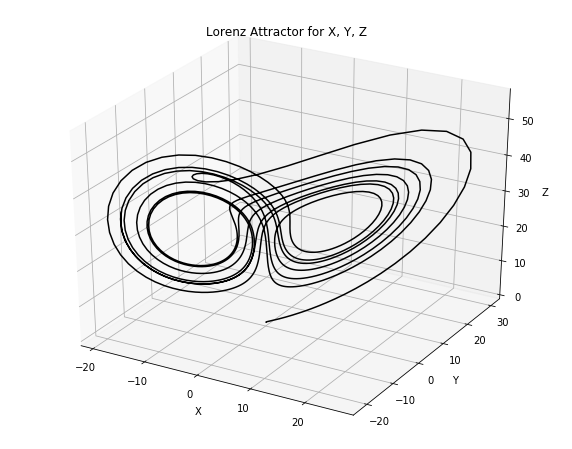

In [13]:
# parameters
t = 0.01
count = 1000
figsize = (10,8)
a, b, c = 20, 28, 8/3.

# generate lorenz attractor
vx, vy, vz = 0.1, 0, 0
sx, sy, sz = [vx], [vy], [vz]

for i in range(count):
    tx = vx + t * a * (vy - vx)
    ty = vy + t * (vx * (b - vz) - vy)
    tz = vz + t * (vx * vy - c * vz)
    
    vx, vy, vz = tx, ty, tz
    
    sx.append(vx)
    sy.append(vy)
    sz.append(vz)

# create 3d plot
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection="3d")
ax.plot(sx, sy, sz, color="k")

# pretty-fy the plot
ax.set_title("Lorenz Attractor for X, Y, Z")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

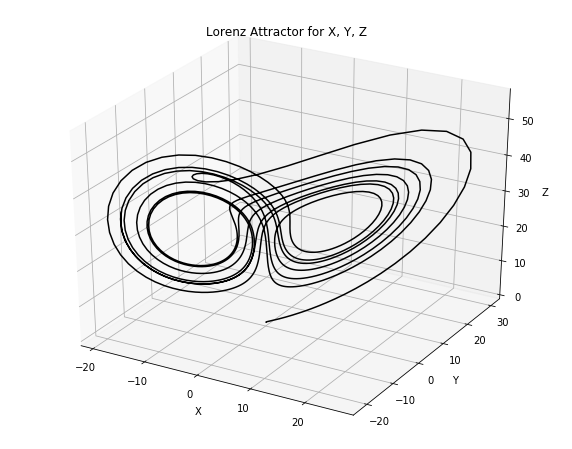

In [14]:
# parameters
t = 0.01
count = 1000
figsize = (10,8)
a, b, c = 20, 28, 8/3.

# generate lorenz attractor
vx, vy, vz = 0.1, 0, 0
sx, sy, sz = [vx], [vy], [vz]

for i in range(count):
    xt = vx + t * a * (vy - vx)
    yt = vy + t * (vx * (b - vz) - vy)
    zt = vz + t * (vx * vy - c * vz)
    
    vx, vy, vz = xt, yt, zt
    
    sx.append(vx)
    sy.append(vy)
    sz.append(vz)

# create 3d plot
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection="3d")
ax.plot(sx, sy, sz, color="k")

# pretty-fy the plot
ax.set_title("Lorenz Attractor for X, Y, Z")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

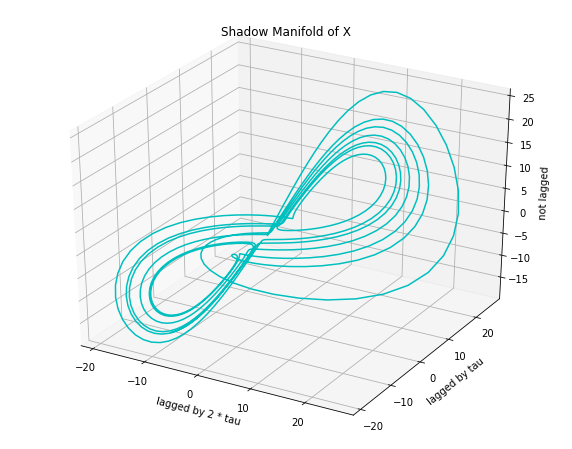

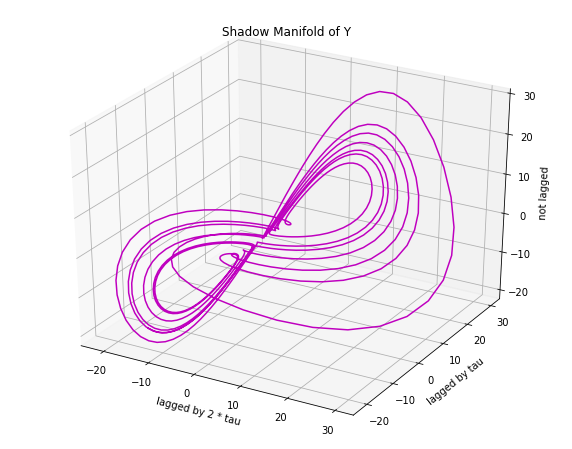

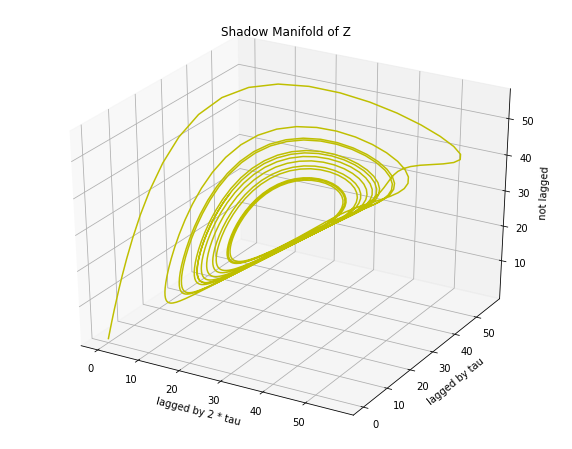

In [15]:
# parameters
tau = 5
colors = ["c", "m", "y"]
labels = ["X", "Y", "Z"]

# plot shadow manifolds
for idx, var in enumerate([sx, sy, sz]):
    # create 3d plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(var[:-2 * tau], var[tau:-tau], var[2 * tau:], color=colors[idx])
    
    # pretty-fy the plot
    ax.set_title("Shadow Manifold of {}".format(labels[idx]))
    ax.set_xlabel("lagged by 2 * tau")
    ax.set_ylabel("lagged by tau")
    ax.set_zlabel("not lagged")

    plt.show()

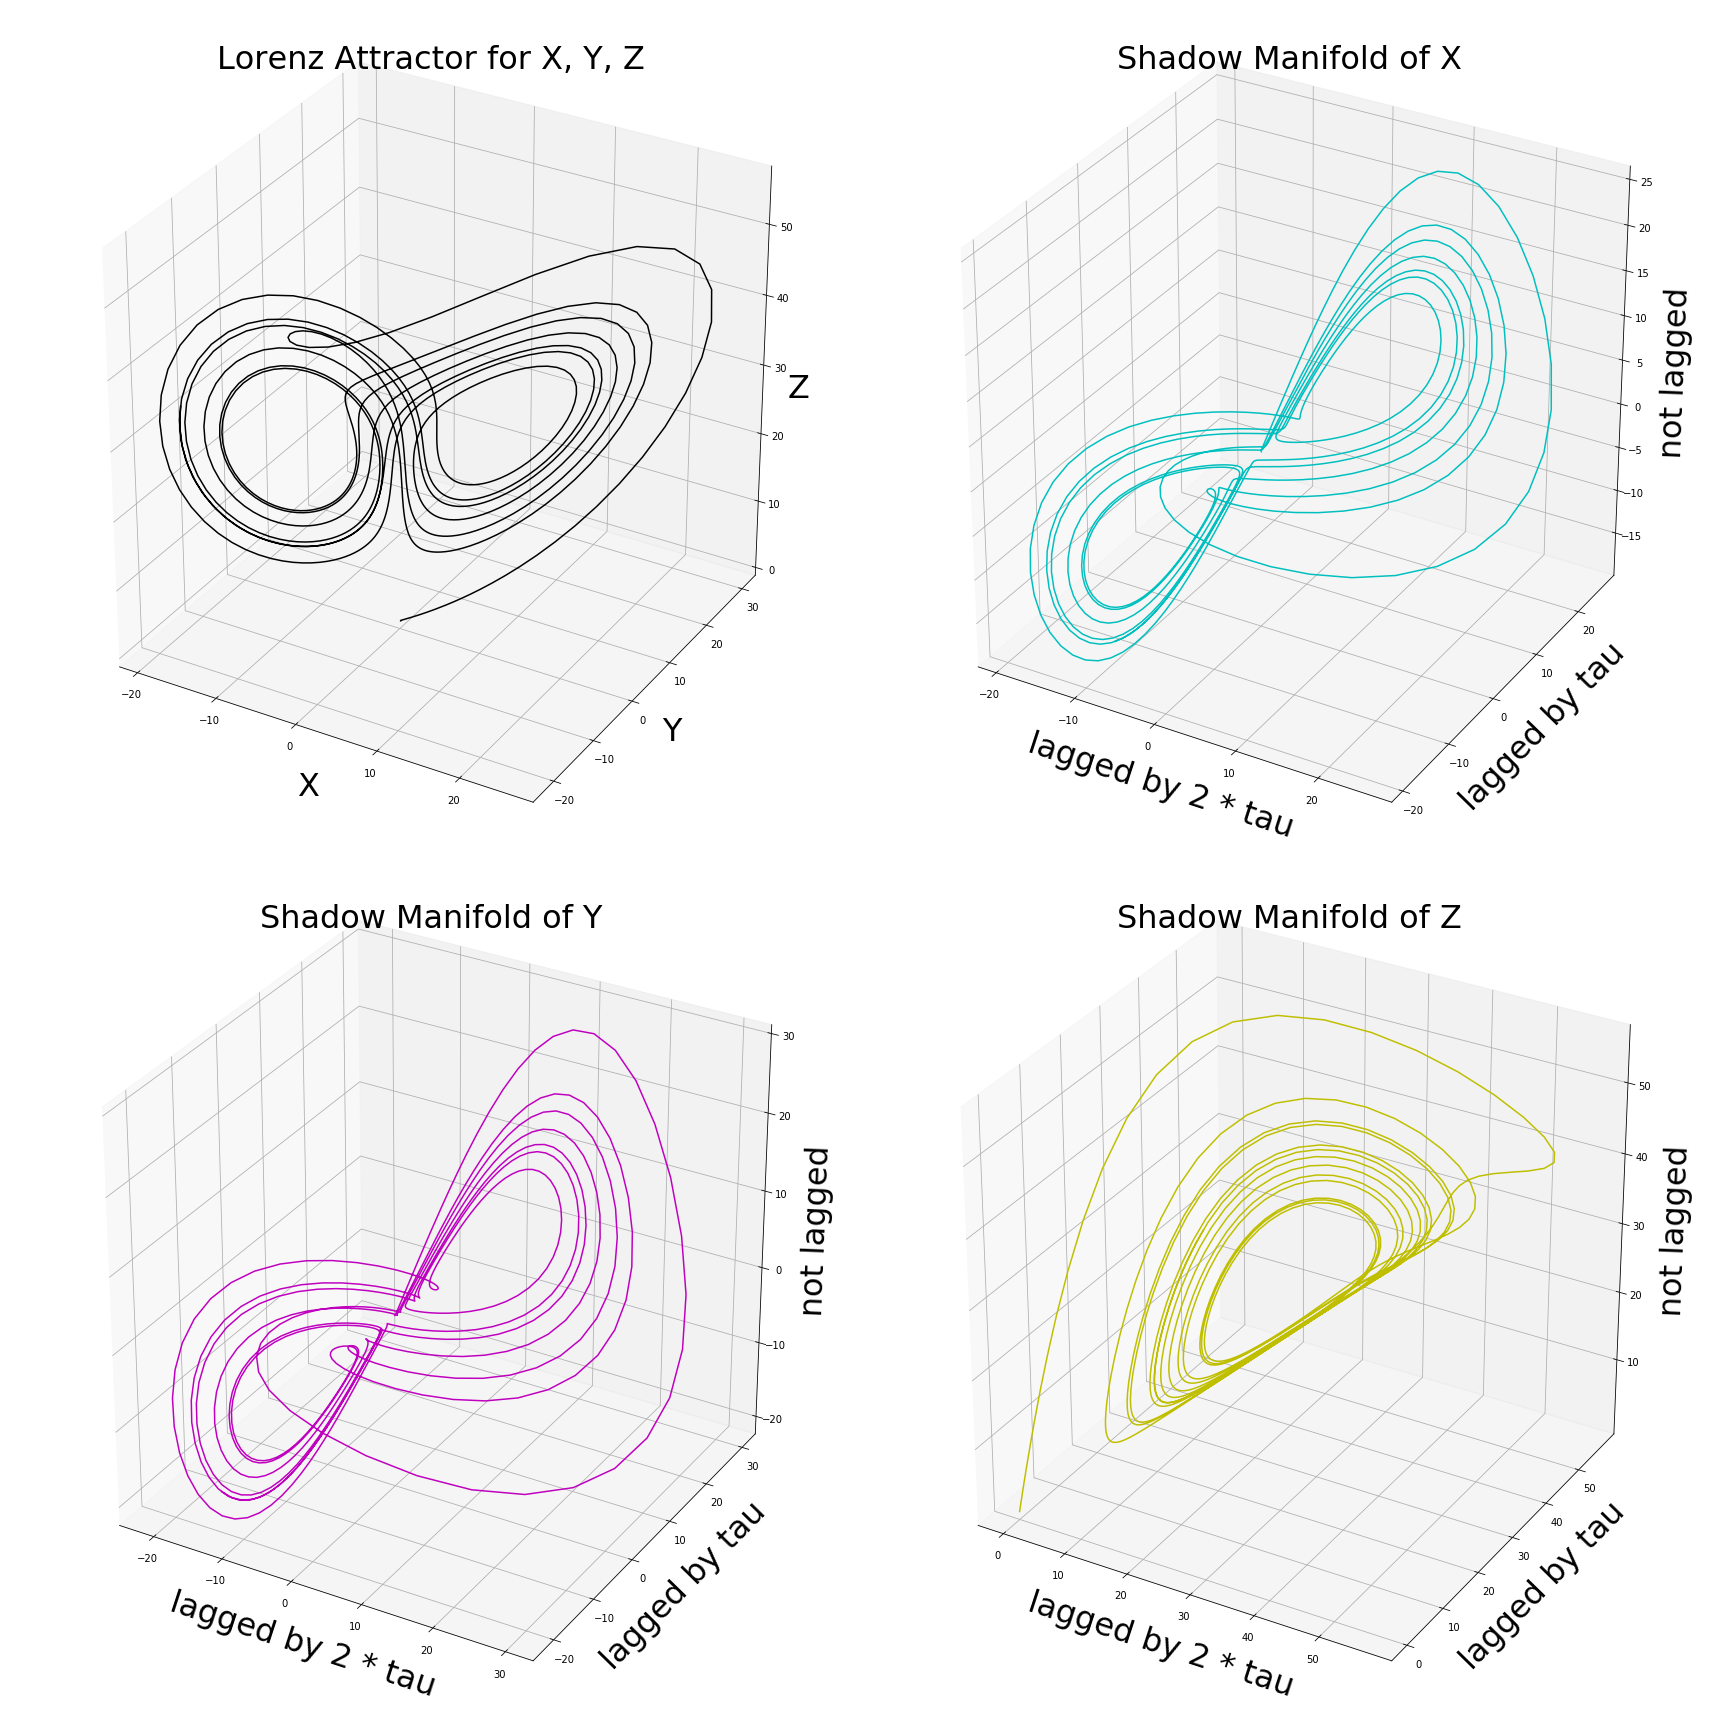

In [16]:
fontsize = 32
fig = plt.figure(figsize=(24,24))
fig.subplots_adjust(top=0.85)

# create the subplots
ax = [
    fig.add_subplot(221, projection="3d"),
    fig.add_subplot(222, projection="3d"),
    fig.add_subplot(223, projection="3d"),
    fig.add_subplot(224, projection="3d")
]

# lorenz attractor
ax[0].plot(sx, sy, sz, color="k")
ax[0].set_title("Lorenz Attractor for X, Y, Z", fontsize=fontsize)
ax[0].set_xlabel("\nX", fontsize=fontsize)
ax[0].set_ylabel("\nY", fontsize=fontsize)
ax[0].set_zlabel("\nZ", fontsize=fontsize)

# shadow manifolds
for idx, var in enumerate([sx, sy, sz]):
    ax[idx + 1].plot(var[:-2 * tau], var[tau:-tau], var[2 * tau:], color=colors[idx])
    
    # pretty-fy the plot
    ax[idx + 1].set_title("Shadow Manifold of {}".format(labels[idx]), fontsize=fontsize)
    ax[idx + 1].set_xlabel("\nlagged by 2 * tau", fontsize=fontsize)
    ax[idx + 1].set_ylabel("\nlagged by tau", fontsize=fontsize)
    ax[idx + 1].set_zlabel("\nnot lagged", fontsize=fontsize)

# show it
plt.tight_layout()
plt.show()
# fig.savefig("/Users/david/Downloads/LorenzAttractor.pdf", bbox_inches="tight")